This code is used to predict the car selling price based on the dataset downloaded from kaggle

In [ ]:
# Import necessary libraries and Scikit learn classes

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to your file on Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/car_prices.csv'

# Try reading the CSV file with a different encoding
df = pd.read_csv(file_path, encoding='latin1',nrows=100000)

# Display the first few rows of the DataFrame
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [ ]:
df.describe()

,year,condition,odometer,mmr,sellingprice
count,100000.000000,88208.000000,99925.000000,100000.000000,100000.000000
mean,2009.293750,29.489037,75147.522172,12558.999500,12230.463520
std,4.256992,13.804882,57711.981006,9321.047724,9333.910641
min,1984.000000,1.000000,1.000000,25.000000,1.000000
25%,2006.000000,21.000000,29568.000000,5475.000000,5100.000000
50%,2011.000000,33.000000,60953.000000,11350.000000,11000.000000
75%,2013.000000,41.000000,110618.000000,17050.000000,16900.000000
max,2015.000000,49.000000,999999.000000,157000.000000,156000.000000


# CHECK NULL VALUE

In [ ]:
print(df.isnull().sum())

year                0
make              425
model             443
trim              696
body             2731
transmission    12000
vin                 0
state               0
condition       11792
odometer           75
color             183
interior          183
seller              0
mmr                 0
sellingprice        0
saledate            0
dtype: int64


Note: Transmission and condition has the highest null value

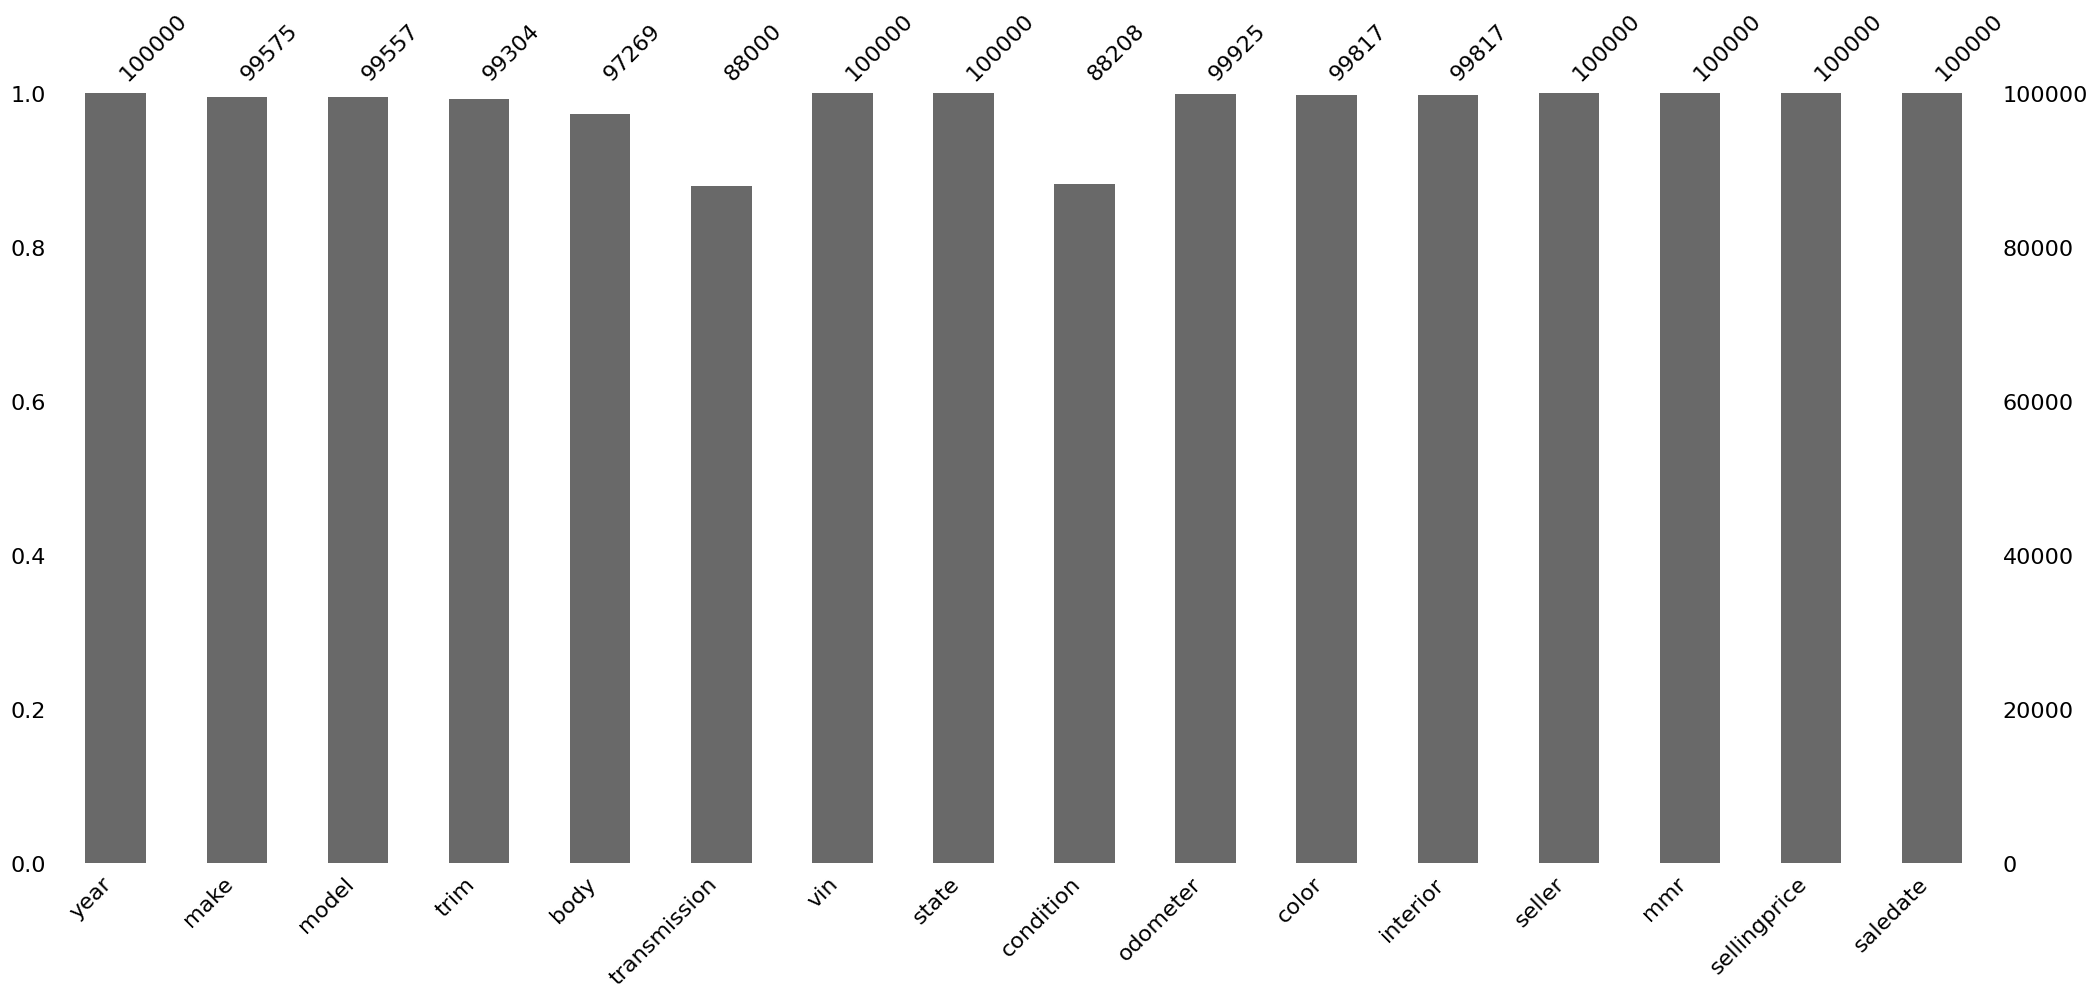

In [ ]:
# prompt: plot a bar graph that show distribution of the missing value

import missingno as msno

# Plot a bar graph that shows the distribution of missing values
msno.bar(df)
plt.show()


In [ ]:
df.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr',
       'sellingprice', 'saledate'],
      dtype='object')

# HANDLING NULL VALUE IN BOTH CATEGORICAL DATA AND NUMERICAL DATA

In [ ]:
# List of categorical columns
categorical_columns = ['make', 'model', 'body', 'trim', 'color', 'interior', 'transmission']

# Impute categorical columns with mode
for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# List of numerical columns
numerical_columns = ['condition', 'odometer']

# Impute numerical columns with mean
for col in numerical_columns:
    df[col] = df[col].fillna(df[col].mean())



The code above will fill in the null value in categorical column with the most frequent value while for numerical it will use the mean method

# CHECK UNIQUE VALUE IN EACH CATEGORICAL DATA

In [ ]:
# List of categorical columns
categorical_columns = ['make', 'model', 'trim', 'body', 'transmission', 'color', 'interior','saledate']

# Create a dictionary to store the count of unique values for each categorical column
unique_counts = {}

# Iterate over the categorical columns
for col in categorical_columns:
    # Get the number of unique values for the current column
    unique_counts[col] = df[col].nunique()

# Create a DataFrame to display the counts of unique values
df_unique_counts = pd.DataFrame(list(unique_counts.items()), columns=['Column', 'Unique Values Count'])

# Display the DataFrame
print(df_unique_counts)

         Column  Unique Values Count
0          make                   93
1         model                  879
2          trim                 1658
3          body                   43
4  transmission                    2
5         color                   20
6      interior                   17
7      saledate                 1579


Column model and trim has a lot of unique value. , if using One Hot Encoder for these 2, it will cause the column to be extremely large which will cause high dimensionality for the preprocessed table. this need to be solve by using dimensional reduction method -- features Hasher

# CHECK CORRELATION SCORE OF FEATURES WITH TARGET FOR NUMERICAL DATA

Correlation matrix:
                  year  condition  odometer       mmr  sellingprice
year          1.000000   0.309356 -0.755435  0.643319      0.631876
condition     0.309356   1.000000 -0.281490  0.280685      0.330129
odometer     -0.755435  -0.281490  1.000000 -0.613605     -0.603622
mmr           0.643319   0.280685 -0.613605  1.000000      0.980963
sellingprice  0.631876   0.330129 -0.603622  0.980963      1.000000


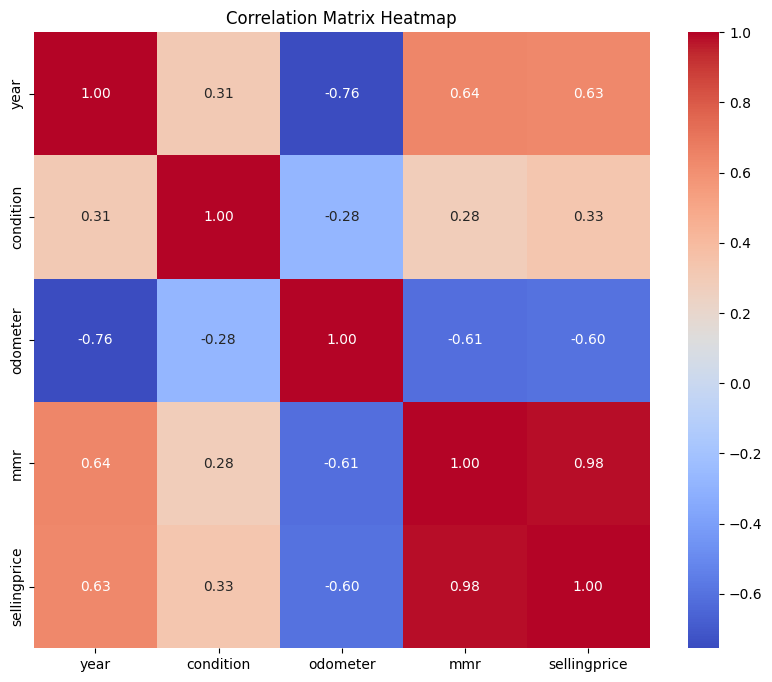

In [ ]:
# List out only the numerical columns
numerical_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

# Display the correlation matrix
print("Correlation matrix:")
print(correlation_matrix)

# Create a heatmap plot
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

# Set title
plt.title("Correlation Matrix Heatmap")

# Display the plot
plt.show()

MMR has the highest correlation following with year and odometer


# CHECK DISTRIBUTION OF DATA IN THE NUMERICAL DATA

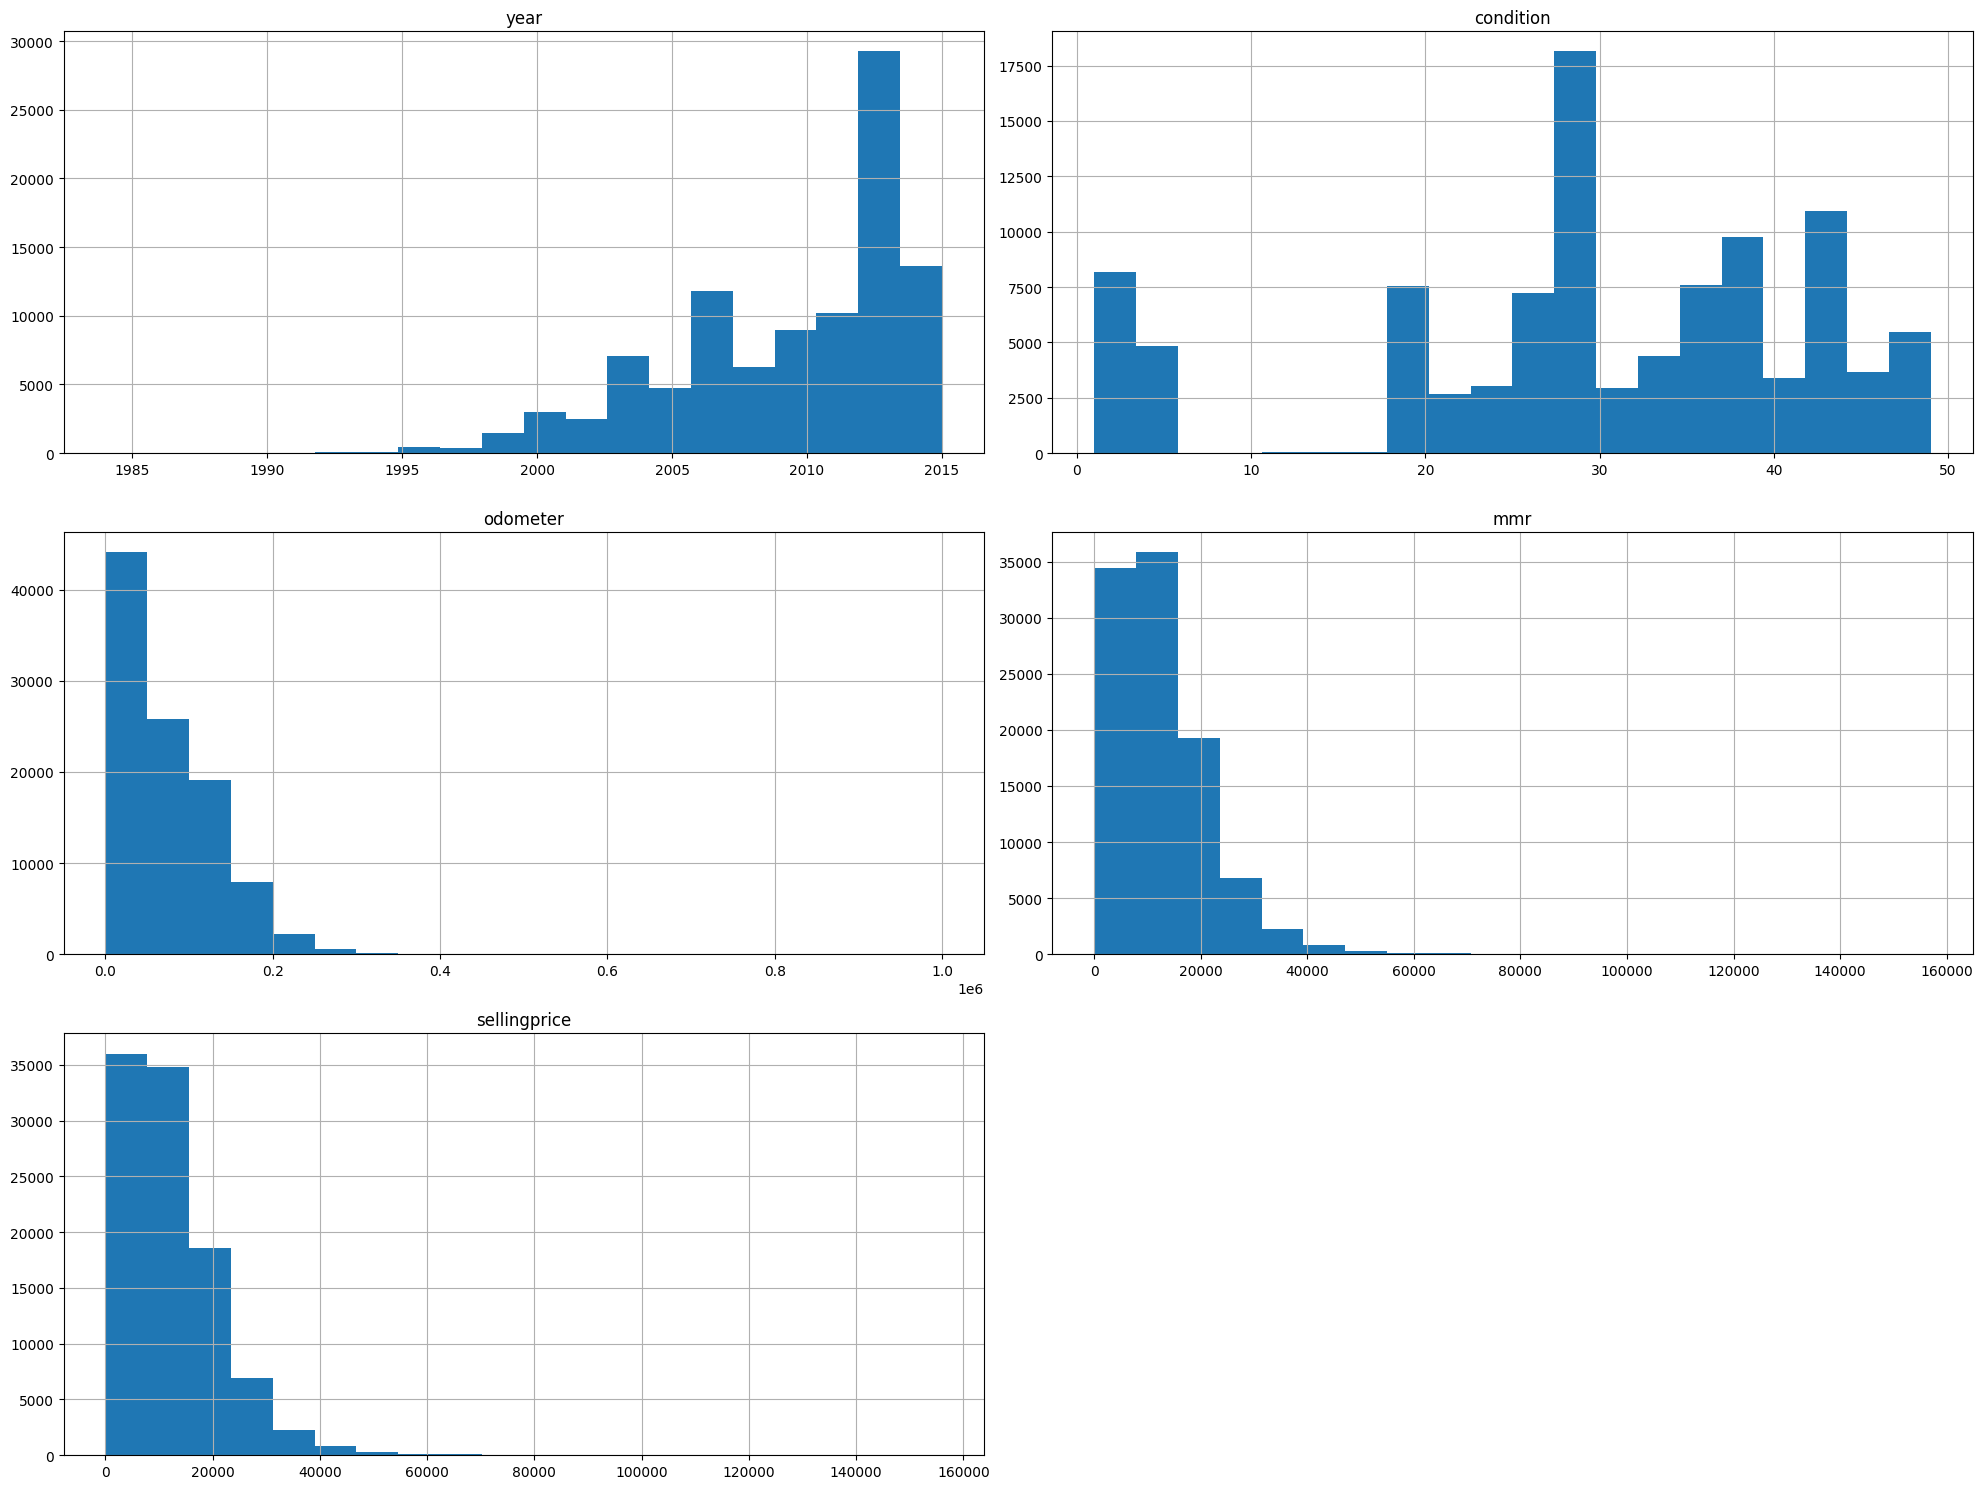

In [ ]:
import matplotlib.pyplot as plt

# Plot a histogram for all columns with smaller bins
df.hist(bins=20, figsize=(20, 15))
plt.tight_layout()  # This will provide better spacing between subplots
plt.show()


Note: All of the value distribution is skewed, need to use log to ensure bell curve distribution for all numerical value

In [ ]:
df.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64

In [ ]:
df.describe()

,year,condition,odometer,mmr,sellingprice
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2009.293750,29.489037,75147.522172,12558.999500,12230.463520
std,4.256992,12.965414,57690.334737,9321.047724,9333.910641
min,1984.000000,1.000000,1.000000,25.000000,1.000000
25%,2006.000000,24.000000,29582.750000,5475.000000,5100.000000
50%,2011.000000,29.489037,61022.500000,11350.000000,11000.000000
75%,2013.000000,39.000000,110590.250000,17050.000000,16900.000000
max,2015.000000,49.000000,999999.000000,157000.000000,156000.000000


# TRAIN TEST SPLIT

In [ ]:
X = df.drop('sellingprice', axis=1)
y = df['sellingprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
df.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr',
       'sellingprice', 'saledate'],
      dtype='object')

# BUILD A PIPELINE

In [ ]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Define the log pipeline for numerical columns
def log_pipeline():
    return make_pipeline(
        FunctionTransformer(np.log1p, validate=False),
        StandardScaler())

# Define the default numerical pipeline
def default_num_pipeline():
    return make_pipeline(
        StandardScaler())

# Define the feature hashing pipeline for high cardinality categorical columns
def hashing_pipeline(n_features):
    return make_pipeline(
        FunctionTransformer(lambda X: FeatureHasher(n_features=n_features, input_type='string').transform(X.applymap(str).values.tolist()).toarray(), validate=False)
    )

# Define the binary encoding function for binary categorical columns
def binary_encode(X):
    return np.where(X == 'Automatic', 1, 0).reshape(-1, 1)

# Define the preprocessing pipeline
preprocessor = ColumnTransformer([
    ("log", log_pipeline(), ["year", "condition", "odometer", "mmr"]),
    ("hash", hashing_pipeline(n_features=10), ["model", "trim", "saledate"]),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse=False), ["make", "body", "color", "interior", "state", "seller"]),
    ("binary", FunctionTransformer(binary_encode, validate=False), ["transmission"])
], remainder='drop')

# Fit and transform the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print(X_train_preprocessed)
print(X_test_preprocessed)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[[ 0.63655625  0.71374902 -0.86500237 ...  0.          0.
   0.        ]
 [-1.94780626 -2.70881366  0.94575634 ...  0.          0.
   0.        ]
 [-0.06686667 -0.29107951  0.90948269 ...  0.          0.
   0.        ]
 ...
 [-0.3015743   0.74238895  0.1021446  ...  0.          0.
   0.        ]
 [ 0.63655625  0.71374902 -0.34092534 ...  0.          0.
   0.        ]
 [-0.3015743   0.2462619   0.38630032 ...  0.          0.
   0.        ]]
[[ 1.1049227  -2.34218489 -0.82583587 ...  0.          0.
   0.        ]
 [ 0.63655625 -2.05780552 -0.71680465 ...  0.          0.
   0.        ]
 [-0.77134026  0.45800958  0.58453367 ...  0.          0.
   0.        ]
 ...
 [ 0.63655625  0.42210796  0.03931443 ...  0.          0.
   0.        ]
 [ 0.63655625  0.18244979 -0.08780629 ...  0.          0.
   0.        ]
 [ 0.63655625  0.59228349 -0.07482    ...  0.          0.
   0.        ]]



### Function Definitions
- **log_pipeline()**:
  - Creates a pipeline that applies a logarithmic transformation followed by standard scaling to numerical columns.
  - `FunctionTransformer(np.log1p, validate=False)`: Applies the log1p (log(1 + x)) transformation to handle positive numerical values.
  - `StandardScaler()`: Standardizes features by removing the mean and scaling to unit variance.

- **default_num_pipeline()**:
  - Creates a pipeline that applies standard scaling to numerical columns.
  - `StandardScaler()`: Standardizes features by removing the mean and scaling to unit variance.

- **hashing_pipeline(n_features)**:
  - Creates a pipeline that applies feature hashing to high-cardinality categorical columns.
  - `FunctionTransformer(lambda X: FeatureHasher(n_features=n_features, input_type='string').transform(X.applymap(str).values.tolist()).toarray(), validate=False)`: Applies feature hashing using a lambda function to convert the data into hashed feature vectors.

- **binary_encode(X)**:
  - Defines a custom binary encoding function for binary categorical columns.
  - `np.where(X == 'Automatic', 1, 0).reshape(-1, 1)`: Encodes 'Automatic' as 1 and other values as 0, reshaping the result to a column vector.

### Preprocessing Pipeline
- **preprocessor**:
  - Combines various preprocessing pipelines for different columns using `ColumnTransformer`.
  - `("log", log_pipeline(), ["year", "condition", "odometer", "mmr"])`: Applies the log pipeline to the columns 'year', 'condition', 'odometer', and 'mmr' as all of these numerical data is skewed.
  - `("hash", hashing_pipeline(n_features=10), ["model", "trim", "saledate"])`: Applies feature hashing to the columns 'model', 'trim', and 'saledate' as these catgeorical data has too many  unique value.
  - `("onehot", OneHotEncoder(handle_unknown='ignore', sparse=False), ["make", "body", "color", "interior", "state", "seller"])`: Applies one-hot encoding to the columns 'make', 'body', 'color', 'interior', 'state', and 'seller'.
  - `("binary", FunctionTransformer(binary_encode, validate=False), ["transmission"])`: Applies the binary encoding function to the 'transmission' column.
  - `remainder='drop'`: Drops columns not specified in the transformers.


In [ ]:
### Linear Regression ###

from sklearn.linear_model import LinearRegression

# Define the pipeline with Linear Regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
%time model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


CPU times: user 17min 56s, sys: 5min 15s, total: 23min 11s
Wall time: 2min 24s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['year', 'condition',
                                                   'odometer', 'mmr']),
                                                 ('hash',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function hashing_pipeline.<locals>.<lambda> at 0x7c2aac5601f0>))]),
                                                  ['model', 'trim',
                                                   'saledate']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['make', 'body', 'color',
                                                   'interior', 'state',
                                                   'seller']),
                                                 ('binary',
                                                  FunctionTransformer(func=<function binary_encode at 0x7c2aac503910>),
                                                  ['transmission'])])),
                ('regressor', LinearRegression())])

# TEST USING LINEAR REGRESSION

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define the regression model
regressor = LinearRegression()

# Fit the regression model using the preprocessed training data
regressor.fit(X_train_preprocessed, y_train)

# Make predictions using the preprocessed training and test data
y_train_pred = regressor.predict(X_train_preprocessed)
y_test_pred = regressor.predict(X_test_preprocessed)

# Calculate RMSE
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print("Training RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


Training RMSE: 3846.798541626387
Test RMSE: 717235368933.6205


Note: Linear Regression perform the worse out of all model tested

# TEST USING DECISION TREE

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Define the regression model
regressor = DecisionTreeRegressor(max_depth=16, random_state=42)

# Fit the regression model using the preprocessed training data
%time regressor.fit(X_train_preprocessed, y_train)

# Make predictions using the preprocessed training and test data
y_train_pred = regressor.predict(X_train_preprocessed)
y_test_pred = regressor.predict(X_test_preprocessed)

# Calculate RMSE
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print("Training RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


CPU times: user 28.1 s, sys: 384 ms, total: 28.5 s
Wall time: 28.4 s
Training RMSE: 1077.5188508775093
Test RMSE: 1719.1598542017348


# TEST USING RANDOM FOREST WITH 100 TREE


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define the regression model
regressor = RandomForestRegressor(n_estimators=100, max_depth=16, random_state=42)

# Fit the regression model using the preprocessed training data
%time regressor.fit(X_train_preprocessed, y_train)

# Make predictions using the preprocessed training and test data
y_train_pred = regressor.predict(X_train_preprocessed)
y_test_pred = regressor.predict(X_test_preprocessed)

# Calculate RMSE
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print("Training RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


CPU times: user 25min 9s, sys: 1.01 s, total: 25min 10s
Wall time: 25min 4s
Training RMSE: 1068.1567649202873
Test RMSE: 1506.3441244578255


Note: Random Forest perform the best out of all model

# TEST USING ENSEMBLE LEARNING (COMBINING DECISION TREE, RANDOM FOREST AND EXTRA TREE REGRESSOR)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error

# Define the base regressors
reg1 = DecisionTreeRegressor(max_depth=16, random_state=42)
reg2 = RandomForestRegressor(random_state=42)
reg3 = ExtraTreesRegressor(random_state=42)

# Define the voting regressor
voting_regressor = VotingRegressor(
    estimators=[
        ('dt', reg1),
        ('rf', reg2),
        ('xtra', reg3)
    ]
)

# Fit the voting regressor using the preprocessed training data
%time voting_regressor.fit(X_train_preprocessed, y_train)

# Make predictions using the preprocessed training and test data
y_train_pred_vot = voting_regressor.predict(X_train_preprocessed)
y_test_pred_vot = voting_regressor.predict(X_test_preprocessed)

# Calculate RMSE
train_rmse = mean_squared_error(y_train, y_train_pred_vot, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred_vot, squared=False)

print("Training RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


CPU times: user 1h 41min 26s, sys: 6.57 s, total: 1h 41min 32s
Wall time: 1h 41min 9s
Training RMSE: 505.3573611571199
Test RMSE: 1513.8767323761854
